In [ ]:
import h5py
import numpy as np

def load_ascad_fixed_key(file_path):
  with h5py.File(file_path, "r") as f:
    X_profiling = np.array(f['Profiling_traces/traces'])
    Y_profiling = np.array(f['Profiling_traces/labels'])

    metadata = f['Profiling_traces/metadata']
    plaintext = np.array(metadata['plaintext'])
    key = np.array(metadata['key'])

    return X_profiling, Y_profiling, plaintext, key

In [ ]:
ascad_path = '/content/drive/MyDrive/ASCAD_databases/ASCAD.h5'
X_profiling, Y_profiling, plaintext, key = load_ascad_fixed_key(ascad_path)

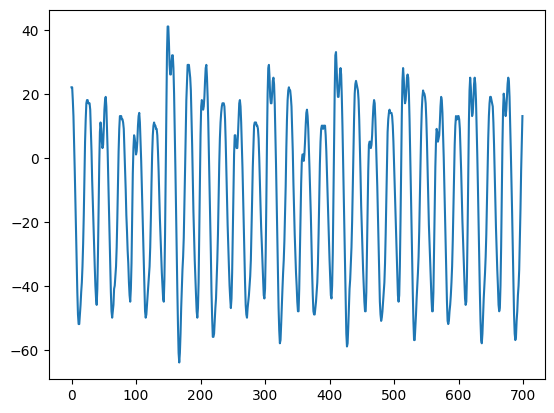

In [ ]:
import matplotlib.pyplot as plt
plt.plot(X_profiling[100])

In [ ]:
snr_ascad = calculate_snr(X_profiling, Y_profiling)

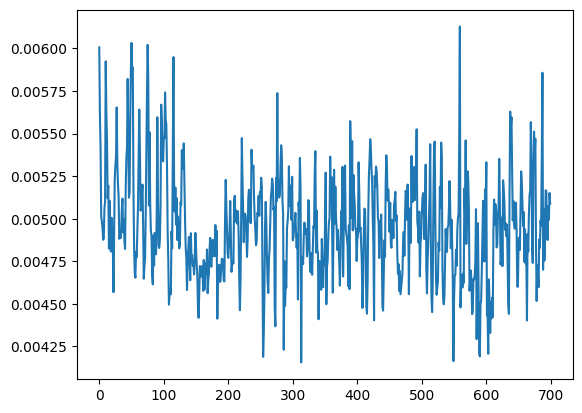

In [ ]:
plt.plot(snr_ascad)

In [ ]:
npz_path = '/content/drive/MyDrive/traces.npz'

data = np.load(npz_path)

traces=data["traces"]
labels=data["labels"]

In [ ]:
traces.shape

(5000, 1000)

In [ ]:
labels.shape

(5000, 16)

In [ ]:
target_byte = 2
labels_byte_2 = labels[:, target_byte]

array([156,  28, 208, ...,  31,  35,  42])

In [ ]:
def calculate_snr(traces, labels):
  snr = []
  for t in range(traces.shape[1]):
    print(f"Trace {t} / {traces.shape[1]} ({t/traces.shape[1] * 100}%)")
    class_means = []
    class_vars = []
    for c in range(256):
      # print(f"Class {c} / 256 ({c/256 * 100}%)")
      class_indices = np.where(labels == c)[0]
      if len(class_indices) == 0:
        continue
      samples = traces[class_indices, t]
      class_means.append(np.mean(samples))
      class_vars.append(np.var(samples))
    if len(class_vars) > 0:
      snr_t = np.var(class_means) / np.mean(class_vars)
    else:
      snr_t = 0
    snr.append(snr_t)
  return np.array(snr)

In [ ]:
# import h5py
# import numpy as np

# def load_ascad_raw(file_path):
#   with h5py.File(file_path, "r") as f:
#     X_profiling = np.array(f['Profiling_traces/traces'])
#     Y_profiling = np.array(f['Profiling_traces/labels'])

#     metadata = f['Profiling_traces/metadata']
#     plaintext = np.array(metadata['plaintext'])
#     key = np.array(metadata['key'])

#     return X_profiling, Y_profiling, plaintext, key

ascad_path_raw = '/content/drive/MyDrive/ASCAD_databases/ATMega8515_raw_traces.h5'
# X_profiling, Y_profiling, plaintext, key = load_ascad_fixed_key(ascad_path_raw)

file_raw = h5py.File(ascad_path_raw, "r")

In [ ]:
raw_traces = file_raw['traces']

In [ ]:
key = file_raw['metadata']['key']

In [ ]:
pt = file_raw['metadata']['plaintext']

In [ ]:
pt[:, 2]

array([195, 174, 195, ...,  92, 238,  99], dtype=uint8)

In [ ]:
key[:, 2].shape

(60000,)

In [ ]:
l = AES_Sbox[key[:, 2] ^ pt[:, 2]]

In [ ]:
chunk_of_traces = raw_traces[:, 40000:60000]

In [ ]:
chunk_of_traces.shape

(60000, 20000)

In [ ]:
l.shape

(60000,)

In [ ]:
snr_raw = calculate_snr(chunk_of_traces[:5000], l[:5000])

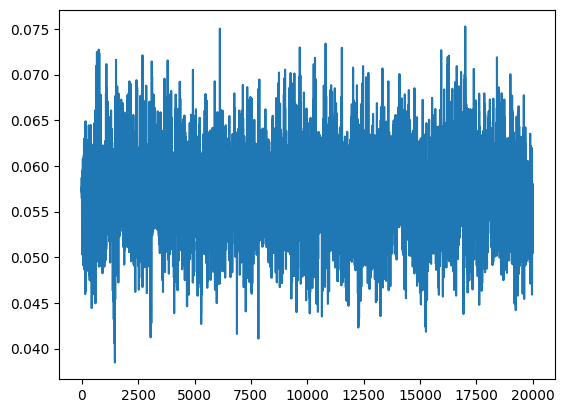

In [ ]:
import matplotlib.pyplot as plt
plt.plot(snr_raw)

In [ ]:
snr_simulated = calculate_snr(traces, labels)

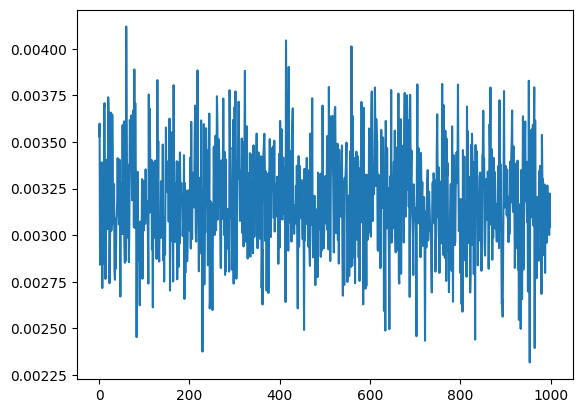

In [ ]:
import matplotlib.pyplot as plt
plt.plot(snr_simulated)

In [ ]:
pois = np.argsort(snr_simulated)[-5:][::-1]
print(f"Top leakage POIs: {pois}")

Top leakage POIs: [ 60 414 559 420  78]


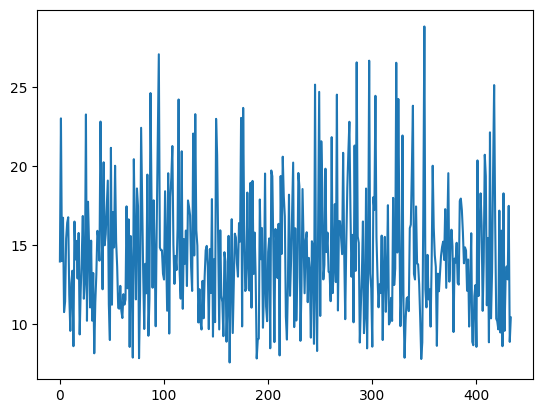

In [ ]:
X_selected = traces[:, pois[0]-350 : pois[0]+350]
labels_selected = labels[pois[0]-350 : pois[0]+350]

X_selected_snr = calculate_snr(X_selected, labels)

plt.plot(X_selected_snr)

In [ ]:
atk_md = 0
with h5py.File(ascad_path, "r") as f:
    X_attack = np.array(f['Attack_traces/traces'])
    Y_attack = np.array(f['Attack_traces/labels'])

    atk_metadata = f['Attack_traces/metadata']
    atk_md = atk_metadata

    attack_plaintext = np.array(atk_metadata['plaintext'])
    attack_ciphertext = np.array(atk_metadata['ciphertext'])
    attack_key = np.array(atk_metadata['key'])

In [ ]:
atk_traces_simulated_path = '/content/drive/MyDrive/atk_traces.npz'

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Activation, Dropout
from tensorflow.keras.utils import to_categorical

def build_mlp_model(input_dim, output_dim=256):
  model = Sequential()

  model.add(Dense(200, input_shape=(input_dim,), activation='relu' ))
  model.add(BatchNormalization())
  # model.add(Dropout(0.2))

  model.add(Dense(200, activation='relu'))
  model.add(BatchNormalization())
  # model.add(Dropout(0.2))

  model.add(Dense(200, activation='relu'))
  model.add(BatchNormalization())
  # model.add(Dropout(0.2))

  model.add(Dense(200, activation='relu'))
  model.add(BatchNormalization())
  # model.add(Dropout(0.2))

  model.add(Dense(200, activation='relu'))
  model.add(BatchNormalization())
  # model.add(Dropout(0.2))

  model.add(Dense(200, activation='relu'))
  model.add(BatchNormalization())
  # model.add(Dropout(0.2))

  model.add(Dense(output_dim, activation='softmax'))
  return model

In [ ]:
y = to_categorical(Y_profiling, num_classes=256)

In [ ]:
traces.shape

(5000, 1000)

In [ ]:
data_sim = np.load(atk_traces_simulated_path)

atk_traces=data_sim["traces"]
atk_labels=data_sim["labels"]

In [ ]:
plaintexts_sim = data_sim['plaintexts']

In [ ]:
key_atk_sim = data_sim["key"]

In [ ]:
key_atk_sim = np.tile(key_atk_sim, (2000, 1))

In [ ]:
labels_byte_2 = labels[:, 2]

In [ ]:
labels_byte_2 = to_categorical(labels_byte_2, num_classes=256)

In [ ]:
labels_byte_2.shape

(5000, 256)

In [ ]:
from tensorflow.keras.optimizers import Adam, RMSprop

y_simulated = to_categorical(labels_byte_2, num_classes=256)

model_simulated = build_mlp_model(traces.shape[1])
model_simulated.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])

model_simulated.fit(traces, labels_byte_2, batch_size=100, epochs=50, validation_split=0.2)

NameError: name 'traces' is not defined

In [ ]:
y_simulated.shape

(0, 16, 256)

In [ ]:
from tensorflow.keras.optimizers import Adam, RMSprop

model = build_mlp_model(X_profiling.shape[1])
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])

model.fit(X_profiling, y, batch_size=200, epochs=200, validation_split=0.1)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/200
225/225 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - accuracy: 0.0038 - loss: 5.9525 - val_accuracy: 0.0046 - val_loss: 5.8623
Epoch 2/200
225/225 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.0060 - loss: 5.7611 - val_accuracy: 0.0050 - val_loss: 5.9304
Epoch 3/200
225/225 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.0079 - loss: 5.6375 - val_accuracy: 0.0048 - val_loss: 5.8696
Epoch 4/200
225/225 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.0088 - loss: 5.5631 - val_accuracy: 0.0060 - val_loss: 5.7583
Epoch 5/200
225/225 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.0111 - loss: 5.5085 - val_accuracy: 0.0032 - val_loss: 5.7608
Epoch 6/200
225/225 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.0125 - loss: 5.4600 - val_accuracy: 0.0042 - val_loss: 5.7898
Epoch 7/200
225/225 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.0156 - loss: 5.4232 - val_accuracy: 0.0028 - val_loss: 5.7748
Epoch 8/200
225/225 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.0166 - loss: 5.3868 - 

In [ ]:
model.save('/content/drive/MyDrive/MLP_PoC.keras')

In [ ]:
model_simulated.save('/content/drive/MyDrive/MLP_PoC_simulated.keras')

In [ ]:
X_attack.shape

(10000, 700)

In [ ]:
predictions = model.predict(X_attack)

NameError: name 'model' is not defined

In [ ]:
predictions_sim = model_simulated.predict(atk_traces)

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


In [11]:
AES_Sbox = np.array([
		0x63, 0x7C, 0x77, 0x7B, 0xF2, 0x6B, 0x6F, 0xC5, 0x30, 0x01, 0x67, 0x2B, 0xFE, 0xD7, 0xAB, 0x76,
		0xCA, 0x82, 0xC9, 0x7D, 0xFA, 0x59, 0x47, 0xF0, 0xAD, 0xD4, 0xA2, 0xAF, 0x9C, 0xA4, 0x72, 0xC0,
		0xB7, 0xFD, 0x93, 0x26, 0x36, 0x3F, 0xF7, 0xCC, 0x34, 0xA5, 0xE5, 0xF1, 0x71, 0xD8, 0x31, 0x15,
		0x04, 0xC7, 0x23, 0xC3, 0x18, 0x96, 0x05, 0x9A, 0x07, 0x12, 0x80, 0xE2, 0xEB, 0x27, 0xB2, 0x75,
		0x09, 0x83, 0x2C, 0x1A, 0x1B, 0x6E, 0x5A, 0xA0, 0x52, 0x3B, 0xD6, 0xB3, 0x29, 0xE3, 0x2F, 0x84,
		0x53, 0xD1, 0x00, 0xED, 0x20, 0xFC, 0xB1, 0x5B, 0x6A, 0xCB, 0xBE, 0x39, 0x4A, 0x4C, 0x58, 0xCF,
		0xD0, 0xEF, 0xAA, 0xFB, 0x43, 0x4D, 0x33, 0x85, 0x45, 0xF9, 0x02, 0x7F, 0x50, 0x3C, 0x9F, 0xA8,
		0x51, 0xA3, 0x40, 0x8F, 0x92, 0x9D, 0x38, 0xF5, 0xBC, 0xB6, 0xDA, 0x21, 0x10, 0xFF, 0xF3, 0xD2,
		0xCD, 0x0C, 0x13, 0xEC, 0x5F, 0x97, 0x44, 0x17, 0xC4, 0xA7, 0x7E, 0x3D, 0x64, 0x5D, 0x19, 0x73,
		0x60, 0x81, 0x4F, 0xDC, 0x22, 0x2A, 0x90, 0x88, 0x46, 0xEE, 0xB8, 0x14, 0xDE, 0x5E, 0x0B, 0xDB,
		0xE0, 0x32, 0x3A, 0x0A, 0x49, 0x06, 0x24, 0x5C, 0xC2, 0xD3, 0xAC, 0x62, 0x91, 0x95, 0xE4, 0x79,
		0xE7, 0xC8, 0x37, 0x6D, 0x8D, 0xD5, 0x4E, 0xA9, 0x6C, 0x56, 0xF4, 0xEA, 0x65, 0x7A, 0xAE, 0x08,
		0xBA, 0x78, 0x25, 0x2E, 0x1C, 0xA6, 0xB4, 0xC6, 0xE8, 0xDD, 0x74, 0x1F, 0x4B, 0xBD, 0x8B, 0x8A,
		0x70, 0x3E, 0xB5, 0x66, 0x48, 0x03, 0xF6, 0x0E, 0x61, 0x35, 0x57, 0xB9, 0x86, 0xC1, 0x1D, 0x9E,
		0xE1, 0xF8, 0x98, 0x11, 0x69, 0xD9, 0x8E, 0x94, 0x9B, 0x1E, 0x87, 0xE9, 0xCE, 0x55, 0x28, 0xDF,
		0x8C, 0xA1, 0x89, 0x0D, 0xBF, 0xE6, 0x42, 0x68, 0x41, 0x99, 0x2D, 0x0F, 0xB0, 0x54, 0xBB, 0x16
		])

In [10]:
def calculate_ranks_full(predictions, pts, keys, target_byte=2, rank_step=100):
    num_traces = predictions.shape[0]
    ranks = []
    num_traces_list = list(range(rank_step, num_traces + 1, rank_step))

    for current_num_traces in num_traces_list:
        # Accumulate key probabilities over the current number of traces
        all_key_probabilities = np.zeros(256)  # Initialize once for each set of traces

        for trace_idx in range(current_num_traces):
            plaintext = pts[trace_idx][target_byte]
            correct_key = keys[trace_idx][target_byte]

            key_probabilities = np.zeros(256)
            for key_candidate in range(256):
                sbox_out = AES_Sbox[plaintext ^ key_candidate]
                key_probabilities[key_candidate] += np.log(predictions[trace_idx][sbox_out] + 1e-8)

            all_key_probabilities += key_probabilities  # Accumulate log probabilities

        # Rank the key candidates based on accumulated probabilities
        ranked_keys = np.argsort(all_key_probabilities)[::-1]
        correct_key_rank = np.where(ranked_keys == correct_key)[0][0]
        print(f"Correct key rank: {correct_key_rank}")
        print(f"Correct key: {correct_key}")
        print(f"current_num_traces: {current_num_traces}")
        ranks.append(correct_key_rank)

    return num_traces_list, ranks

In [ ]:
predictions_sim.shape

(2000, 256)

In [ ]:
num_traces_list = list(range(100, 2000 + 1, 100))
num_traces_list

[100,
 200,
 300,
 400,
 500,
 600,
 700,
 800,
 900,
 1000,
 1100,
 1200,
 1300,
 1400,
 1500,
 1600,
 1700,
 1800,
 1900,
 2000]

In [ ]:
num_traces_list, ranks = calculate_ranks_full(predictions, attack_plaintext, attack_key, target_byte=2, rank_step=100)

In [ ]:
num_traces_list, ranks = calculate_ranks_full(predictions_sim, plaintexts_sim, key_atk_sim, target_byte=2, rank_step=100)

Correct key rank: 161
Correct key: 19
current_num_traces: 100
Correct key rank: 60
Correct key: 19
current_num_traces: 200
Correct key rank: 13
Correct key: 19
current_num_traces: 300
Correct key rank: 3
Correct key: 19
current_num_traces: 400
Correct key rank: 1
Correct key: 19
current_num_traces: 500
Correct key rank: 3
Correct key: 19
current_num_traces: 600
Correct key rank: 2
Correct key: 19
current_num_traces: 700
Correct key rank: 2
Correct key: 19
current_num_traces: 800
Correct key rank: 2
Correct key: 19
current_num_traces: 900
Correct key rank: 4
Correct key: 19
current_num_traces: 1000
Correct key rank: 11
Correct key: 19
current_num_traces: 1100
Correct key rank: 17
Correct key: 19
current_num_traces: 1200
Correct key rank: 10
Correct key: 19
current_num_traces: 1300
Correct key rank: 10
Correct key: 19
current_num_traces: 1400
Correct key rank: 33
Correct key: 19
current_num_traces: 1500
Correct key rank: 36
Correct key: 19
current_num_traces: 1600
Correct key rank: 26
Co

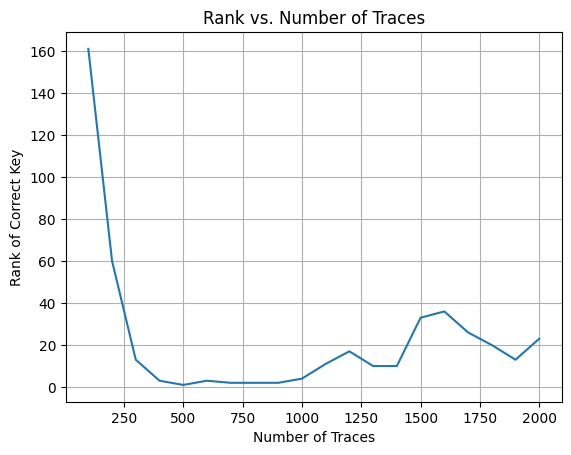

In [ ]:
import matplotlib.pyplot as plt

# Plotting the rank curve
plt.plot(num_traces_list, ranks)
plt.xlabel("Number of Traces")
plt.ylabel("Rank of Correct Key")
plt.title("Rank vs. Number of Traces")
plt.grid(True)
plt.show()

In [ ]:
from scipy.stats import rankdata

def attack(model, traces, plaintexts, keys, key_byte_idx, correct_key_byte):
  predictions = model.predict(traces)
  key_guesses=np.zeros(256)

  for k_guess in range(256):
    sbox_out = np.array([AES_Sbox[p[key_byte_idx] ^ k_guess] for p in plaintexts])
    likelihoods = predictions[np.arange(len(traces)), sbox_out]
    key_guesses[k_guess] = np.sum(np.log(likelihoods + 1e-36))

  best_guess = np.argmax(key_guesses)
  key_rank = 256 - rankdata(key_guesses, method='ordinal')[correct_key_byte]

  print(f"best_guess = {best_guess} | correct_key_byte = {correct_key_byte} | key_rank = {key_rank}")

  return best_guess, correct_key_byte, key_rank


In [ ]:
for e in plaintexts_sim:
  if len(e) != 16:
    print(len(e))
    print(e)
    print("====")

15
b'\x89:\x86\x86\x04\xd1\xce\xaf\x18\xb1\x8e\x12f\xa9V'
====
15
b'\xa5\x8e\xccB\tljb \x1b\x18WM\xa1\x11'
====
15
b'-\xa9\xb2\xed\x95\xcc\xe8\xd3\x84=\x90\x92\xab\x8d2'
====
15
b'#f\xf8\xacw$\x01\xeb\xb9\x90\x91x\xa8B\x05'
====
15
b'\xd2\xe6\xc1\x08\xbd\xfb(\x0b_\x1e\xcc-\x8bj\xb1'
====
15
b'\x14Z%\xe5\xab%\xa689\xb2)Am7\x9e'
====
15
b'\xec\x1e(<\xf5\xf8Q4\x1en\xff<{\x95f'
====
15
b'\xba\xd2\n\xadz\xa0\xcc.\xbe\xfd>\x06\xc8\xd5\x81'
====


In [ ]:
byte_array = plaintexts_sim
hex_arrays = []
for byte_string in byte_array:
    hex_values = [int(hex(byte), 16) for byte in byte_string]
    hex_arrays.append(hex_values)

In [ ]:
numpy_array = np.zeros((2000,16), dtype=np.uint8)

for i, row in enumerate(hex_arrays):
  if len(row) != 16:
        print(f"Error: Row {i} has length {len(row)} (should be 16)")
  else:
    numpy_array[i, :] = row

Error: Row 208 has length 15 (should be 16)
Error: Row 619 has length 15 (should be 16)
Error: Row 1006 has length 15 (should be 16)
Error: Row 1276 has length 15 (should be 16)
Error: Row 1359 has length 15 (should be 16)
Error: Row 1490 has length 15 (should be 16)
Error: Row 1686 has length 15 (should be 16)
Error: Row 1849 has length 15 (should be 16)


In [ ]:
atk_ptxts = numpy_array

In [ ]:
test = np.zeros((2000, 16))

for t in range(len(test)):
  test[t] = np.array(hex_arrays[t])

ValueError: could not broadcast input array from shape (15,) into shape (16,)

In [ ]:
target_byte = 2
correct_key_byte = key_atk_sim[:, target_byte][0]

In [ ]:
attack(model_simulated, atk_traces[:500,], atk_ptxts[:500,], key_atk_sim, target_byte, correct_key_byte)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
best_guess = 19 | correct_key_byte = 19 | key_rank = 0


(np.int64(19), np.int64(19), np.int64(0))

## mbedtls

In [1]:
def load_np_traces(traces_path):

  data = np.load(traces_path)

  traces=data["traces"]
  labels=data["labels"]
  keys=data["keys"]
  plaintext=data["plaintext"]

  return traces, labels, keys, plaintext

In [2]:
import numpy as np

npz_path_mbedtls_masked = '/content/drive/MyDrive/container_traces_mbedtls_masked_valid_v2.npz'
traces_sim_profiling, labels_sim_profiling, keys, pts = load_np_traces(npz_path_mbedtls_masked)

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Activation, Dropout
from tensorflow.keras.utils import to_categorical

def build_mlp_model(input_dim, output_dim=256):
  model = Sequential()

  model.add(Dense(200, input_shape=(input_dim,), activation='relu' ))
  model.add(BatchNormalization())
  # model.add(Dropout(0.2))

  model.add(Dense(200, activation='relu'))
  model.add(BatchNormalization())
  # model.add(Dropout(0.2))

  model.add(Dense(200, activation='relu'))
  model.add(BatchNormalization())
  # model.add(Dropout(0.2))

  model.add(Dense(200, activation='relu'))
  model.add(BatchNormalization())
  # model.add(Dropout(0.2))

  model.add(Dense(200, activation='relu'))
  model.add(BatchNormalization())
  # model.add(Dropout(0.2))

  model.add(Dense(200, activation='relu'))
  model.add(BatchNormalization())
  # model.add(Dropout(0.2))

  model.add(Dense(output_dim, activation='softmax'))
  return model

In [4]:
labels_sim_profiling = labels_sim_profiling.reshape(1000, 16)

In [5]:
labels_byte_2 = labels_sim_profiling[:, 2]

In [6]:
np.all(y_simulated[42] == y_simulated[32])

NameError: name 'y_simulated' is not defined

In [7]:
from tensorflow.keras.optimizers import Adam, RMSprop

y_simulated = to_categorical(labels_byte_2, num_classes=256)

model_simulated = build_mlp_model(traces_sim_profiling.shape[1])
model_simulated.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])

model_simulated.fit(traces_sim_profiling, y_simulated, batch_size=100, epochs=50, validation_split=0.2)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 122ms/step - accuracy: 0.0029 - loss: 5.9296 - val_accuracy: 0.0050 - val_loss: 6.1382
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.0113 - loss: 5.6111 - val_accuracy: 0.0000e+00 - val_loss: 6.1301
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.0218 - loss: 5.3909 - val_accuracy: 0.0000e+00 - val_loss: 6.1088
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0298 - loss: 5.1677 - val_accuracy: 0.0050 - val_loss: 6.0835
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0603 - loss: 4.9402 - val_accuracy: 0.0050 - val_loss: 6.0539
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0927 - loss: 4.6840 - val_accuracy: 0.0050 - val_loss: 6.0178
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.1409 - loss: 4.4326 - val_accuracy: 0.0050 - val_loss: 5.9711
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.2342 - loss: 4.2270 - val_accuracy: 0.0000e+00 - val_

In [8]:
predictions_sim = model_simulated.predict(traces_sim_profiling)

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step


In [12]:
num_traces_list, ranks = calculate_ranks_full(predictions_sim, pts, keys, target_byte=2, rank_step=100)

Correct key rank: 0
Correct key: 190
current_num_traces: 100
Correct key rank: 0
Correct key: 190
current_num_traces: 200
Correct key rank: 0
Correct key: 190
current_num_traces: 300
Correct key rank: 0
Correct key: 190
current_num_traces: 400
Correct key rank: 0
Correct key: 190
current_num_traces: 500
Correct key rank: 0
Correct key: 190
current_num_traces: 600
Correct key rank: 0
Correct key: 190
current_num_traces: 700
Correct key rank: 0
Correct key: 190
current_num_traces: 800
Correct key rank: 0
Correct key: 190
current_num_traces: 900
Correct key rank: 0
Correct key: 190
current_num_traces: 1000


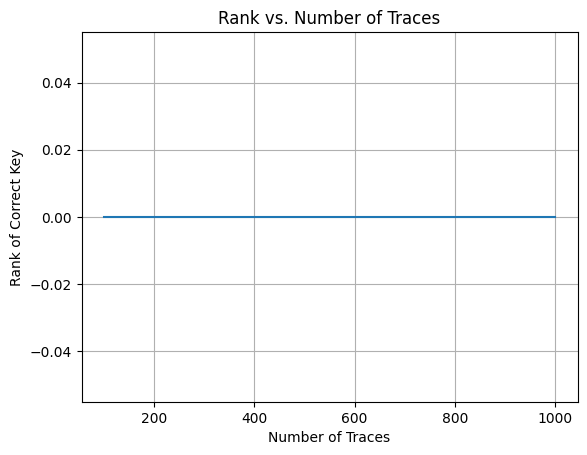

In [13]:
import matplotlib.pyplot as plt

# Plotting the rank curve
plt.plot(num_traces_list, ranks)
plt.xlabel("Number of Traces")
plt.ylabel("Rank of Correct Key")
plt.title("Rank vs. Number of Traces")
plt.grid(True)
plt.show()